<a href="https://colab.research.google.com/github/PhungTrinhUET/Citrus-leaf-diseases/blob/main/12_7_resnet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!unzip "./gdrive/MyDrive/citrus3.zip" -d '/usr/local'


Streaming output truncated to the last 5000 lines.
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (705).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (706).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (707).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (708).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (709).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (710).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (711).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (712).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (713).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (714).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (715).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (716).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (717).jpg  
  inflating: 

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
batch_size = 64
target_size = (224, 224)
validation_split = 0.2

train_gen = tf.keras.preprocessing.image_dataset_from_directory(
    "/usr/local/data_citrus/",
    validation_split=validation_split,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size
)

valid_gen = tf.keras.preprocessing.image_dataset_from_directory(
    "/usr/local/data_citrus/",
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size
)

# Getting class names for the model
class_names = train_gen.class_names
num_classes = len(class_names)


Found 5979 files belonging to 5 classes.
Using 4784 files for training.
Found 5979 files belonging to 5 classes.
Using 1195 files for validation.


In [ ]:
from keras.applications import ResNet101
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD

# Load the ResNet101 model, excluding the top layers
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


171446536/171446536 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet101_best_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(train_gen,
                    epochs=10,
                    validation_data=valid_gen,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/10
75/75 [==============================] - 2326s 31s/step - loss: 0.4647 - accuracy: 0.8418 - val_loss: 0.1641 - val_accuracy: 0.9490
Epoch 2/10
75/75 [==============================] - 2279s 30s/step - loss: 0.1706 - accuracy: 0.9438 - val_loss: 0.1301 - val_accuracy: 0.9582
Epoch 3/10
75/75 [==============================] - 2280s 30s/step - loss: 0.1457 - accuracy: 0.9492 - val_loss: 0.1198 - val_accuracy: 0.9590
Epoch 4/10
75/75 [==============================] - 2317s 31s/step - loss: 0.1341 - accuracy: 0.9538 - val_loss: 0.1088 - val_accuracy: 0.9615
Epoch 5/10
75/75 [==============================] - 2266s 30s/step - loss: 0.1223 - accuracy: 0.9557 - val_loss: 0.1023 - val_accuracy: 0.9615
Epoch 6/10
75/75 [==============================] - 2229s 30s/step - loss: 0.1151 - accuracy: 0.9580 - val_loss: 0.0966 - val_accuracy: 0.9665
Epoch 7/10
75/75 [==============================] - 2210s 30s/step - loss: 0.1105 - accuracy: 0.9613 - val_loss: 0.0987 - val_accuracy: 0.9640

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(valid_gen)
print(f'Validation loss: {val_loss}')
print(f'Validation accuracy: {val_accuracy}')


19/19 [==============================] - 449s 24s/step - loss: 0.0838 - accuracy: 0.9682
Validation loss: 0.08377384394407272
Validation accuracy: 0.9682008624076843


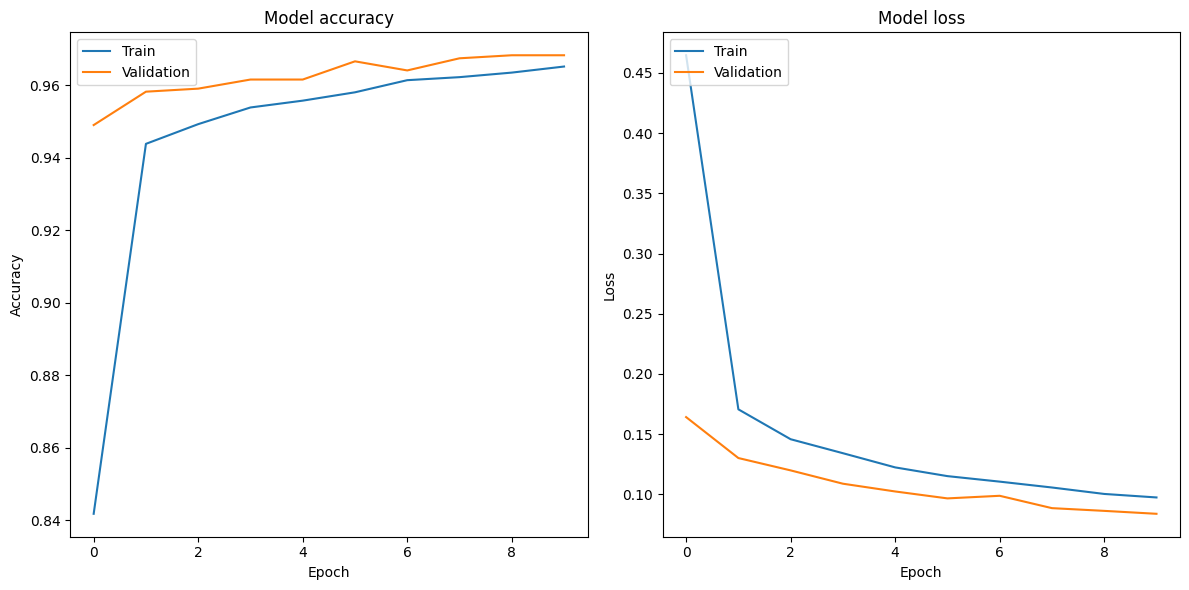

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
import os
import shutil

def get_model_size(model):
    model.save('temp_model')
    size = sum(os.path.getsize(os.path.join('temp_model', f)) for f in os.listdir('temp_model') if os.path.isfile(os.path.join('temp_model', f)))
    size_mb = size / (1024 * 1024)  # Đổi từ byte sang MB
    shutil.rmtree('temp_model')  # Xóa thư mục tạm thời sau khi tính toán
    return size_mb

model_size_mb = get_model_size(model)
print(f'Model size: {model_size_mb:.2f} MB')


Model size: 5.97 MB


In [ ]:
import time
import numpy as np

def get_inference_time(model, input_shape=(224, 224, 3)):
    input_data = np.random.random([1] + list(input_shape)).astype(np.float32)
    start_time = time.time()
    _ = model.predict(input_data)
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000  # Đổi từ giây sang mili giây
    return inference_time_ms

inference_time_ms = get_inference_time(model)
print(f'Speed of single image recognition: {inference_time_ms:.2f} ms')

1/1 [==============================] - 3s 3s/step
Speed of single image recognition: 3443.31 ms


In [ ]:
# Evaluate the model and get predictions
y_true = []
y_pred = []

for images, labels in valid_gen:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

# Convert lists to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate Precision and Recall
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

precision.update_state(y_true, y_pred)
recall.update_state(y_true, y_pred)

precision_score = precision.result().numpy()
recall_score = recall.result().numpy()

print(f'Precision: {precision_score}')
print(f'Recall: {recall_score}')

# Calculate F1 score
f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)
print(f'F1 Score: {f1_score}')


1/2 [==============>...............] - ETA: 12s

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
def display_sample_predictions(generator, model, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in generator.take(1):
        predictions = model.predict(images)
        pred_labels = np.argmax(predictions, axis=1)
        for i in range(min(9, images.shape[0])):
            plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
            plt.axis("off")
    plt.show()

display_sample_predictions(valid_gen, model, class_names)
